# Attempt to decode word end / sentence end

In [2]:
def mne_events(meta, raw, start, level):
    if start=='onset':
        events = np.ones((len(meta), 3), dtype=int)
        events[:, 0] = meta.start * raw.info["sfreq"]
        return dict(events=events, metadata=meta.reset_index())
    elif start=='offset':
        """
        It should generalize, no need for different cases?
        if level == 'word':
            events = np.ones((len(meta), 3), dtype=int)
            events[:, 0] = (meta.start+meta.duration) * raw.info["sfreq"]
            return dict(events=events, metadata=meta.reset_index())
        elif level == 'sentence':
            events = np.ones((len(meta), 3), dtype=int)
            events[:, 0] = (meta.start+meta.duration) * raw.info["sfreq"]
            return dict(events=events, metadata=meta.reset_index())

        else:
            print('hi')
            # Fill
        """
        events = np.ones((len(meta), 3), dtype=int)
        events[:, 0] = (meta.start+meta.duration) * raw.info["sfreq"]
        return dict(events=events, metadata=meta.reset_index())
        
    else:
        print('start should be either onset or offset')
        return 0
        
        


In [3]:
from dataset import read_raw, get_subjects, get_path
from utils import decod_xy
import mne
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import match_list
import spacy

path = get_path("LPP_read")
subjects = get_subjects(path)
task = "read"
# Debug
runs = 9

level = 'word' # Sentence or word

epoch_windows = {"word": {"onset_min": -0.25, "onset_max": 0.25, "offset_min": -0.55, "offset_max": 0.05},
                  "constituent": {"offset_min": -2.0, "offset_max": 0.5, "onset_min": -0.5, "onset_max": 2.0},
                  "sentence": {"offset_min": -4.0, "offset_max": 1.0, "onset_min": -1.0, "onset_max": 4.0}}
start = 'onset'

subject = subjects[2]
all_epochs = []
for run in range(1,runs+1):

    # Set the metadata for this case
    raw, meta_, events = read_raw(subject, run, events_return = True)
    meta = meta_.copy()
    # Metadata update
    # Word start
    meta['word_onset'] = True
    meta['word_stop'] = meta.start + meta.duration

    # Sent start
    meta['sentence_onset'] = meta.word_id == 0

    # Const start
    meta['prev_closing'] = meta['n_closing'].shift(1)
    meta['constituent_onset'] = meta.apply(lambda x: x['prev_closing'] > x['n_closing'] and x['n_closing'] == 1, axis=1)
    meta['constituent_onset'].fillna(False, inplace=True)
    meta.drop('prev_closing', axis=1, inplace=True)

    # Adding the sentence stop info
    meta['sentence_id'] = np.cumsum(meta.sentence_onset)
    for s, d in meta.groupby('sentence_id'):
        meta.loc[d.index, 'sentence_start'] = d.start.min()

    # Adding the constituents stop info
    meta['constituent_id'] = np.cumsum(meta.constituent_onset)
    for s, d in meta.groupby('constituent_id'):
        meta.loc[d.index, 'constituent_start'] = d.start.min()



    # Select either the sentence end to decode, or the word end
    sel = meta.query(f'{level}_onset==True')
    assert sel.shape[0] > 10  #
    # TODO check variance as well for sentences
    # Matchlist events and meta
    # So that we can epoch now that's we've sliced our metadata
    i, j = match_list(events[:, 2], sel.word.apply(len))
    sel = sel.reset_index().loc[j]
    # Making sure there is not hidden bug when matching
    assert sel.shape[0] > 0.8 *  (meta.query(f'{level}_onset==True')).shape[0]

    # Epoching from the metadata having all onset events: if the start=Offset, the mne events
    # Function will epoch on the offset of each level instead of the onset
    # TODO: add adaptative baseline
    epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 10,
                         tmin = epoch_windows[f'{level}'][f'{start}_min'],
                           tmax = epoch_windows[f'{level}'][f'{start}_max'],
                             event_repeated = 'drop', # check event repeated
                                preload=True,
                                    baseline=None)  # n_words OR n_constitutent OR n_sentences
    epoch_key = f'{level}_{start}'

    all_epochs.append(epochs)



 Epoching for run 1, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 36000 ... 517999 =     36.000 ...   517.999 secs
Ready.
Reading events from /home/is153802/data/LPP_MEG_

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Omitted 81 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Trigger channel has a non-zero initial value of 8 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1466 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Reading 0 ... 481999  =      0.000 ...   481.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.2s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 23 columns
1405 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1405 events and 501 original time points (prior to decimation) ...


/tmp/ipykernel_85500/3814198236.py:71: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 10,


1 bad epochs dropped

 Epoching for run 2, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 14000 ... 532999 =     14.000 ...   532.999 secs
Ready.
Reading events from /home/i

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Omitted 99 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010,

1607 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Reading 0 ... 518999  =      0.000 ...   518.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 23 columns
1560 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1560 events and 501 original time points (prior to decimation) ...


/tmp/ipykernel_85500/3814198236.py:71: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 10,


1 bad epochs dropped

 Epoching for run 3, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-03_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 12000 ... 566999 =     12.000 ...   566.999 secs
Ready.
Reading events from /home/i

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Omitted 146 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010

1719 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Reading 0 ... 554999  =      0.000 ...   554.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.0s finished


Adding metadata with 23 columns
1659 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1659 events and 501 original time points (prior to decimation) ...


/tmp/ipykernel_85500/3814198236.py:71: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 10,


1 bad epochs dropped

 Epoching for run 4, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-04_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 11000 ... 500999 =     11.000 ...   500.999 secs
Ready.
Reading events from /home/i

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Omitted 134 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1491 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19]
Reading 0 ... 489999  =      0.000 ...   489.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.5s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 23 columns
1438 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1438 events and 501 original time points (prior to decimation) ...


/tmp/ipykernel_85500/3814198236.py:71: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 10,


1 bad epochs dropped

 Epoching for run 5, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-05_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 12000 ... 472999 =     12.000 ...   472.999 secs
Ready.
Reading events from /home/i

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Omitted 121 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010

1373 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 20]
Reading 0 ... 460999  =      0.000 ...   460.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.2s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 23 columns
1333 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1333 events and 501 original time points (prior to decimation) ...


/tmp/ipykernel_85500/3814198236.py:71: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 10,


1 bad epochs dropped

 Epoching for run 6, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-06_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 9000 ... 575999 =      9.000 ...   575.999 secs
Ready.
Reading events from /home/is

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Omitted 139 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010

1698 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Reading 0 ... 566999  =      0.000 ...   566.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.7s finished


Adding metadata with 23 columns
1695 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1695 events and 501 original time points (prior to decimation) ...
0 bad epochs dropped

 Epoching for run 7, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-07_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Omitted 140 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010

1553 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Reading 0 ... 514999  =      0.000 ...   514.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.0s finished


Adding metadata with 23 columns
1552 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1552 events and 501 original time points (prior to decimation) ...
0 bad epochs dropped

 Epoching for run 8, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-08_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Omitted 116 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010

1390 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 19 21]
Reading 0 ... 449999  =      0.000 ...   449.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    5.9s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 23 columns
1315 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1315 events and 501 original time points (prior to decimation) ...


/tmp/ipykernel_85500/3814198236.py:71: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 10,


1 bad epochs dropped

 Epoching for run 9, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-09_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 9000 ... 553999 =      9.000 ...   553.999 secs
Ready.
Reading events from /home/is

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Omitted 148 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/testing/alex_collab/dataset.py:51: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010

1654 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Reading 0 ... 544999  =      0.000 ...   544.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.0s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 23 columns
1577 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1577 events and 501 original time points (prior to decimation) ...


/tmp/ipykernel_85500/3814198236.py:71: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 10,


1 bad epochs dropped


In [4]:
for epo in all_epochs:
    epo.info["dev_head_t"] = all_epochs[1].info["dev_head_t"]

all_epochs = mne.concatenate_epochs(all_epochs)

# Decode
epochs = epochs.load_data().pick_types(meg=True, stim=False, misc=False)
X = epochs.get_data()
y = epochs.metadata.word
"""
R_vec = decod_xy(X, embeddings)
scores = np.mean(R_vec, axis=1)

for t, score in enumerate(scores):
    all_scores.append(dict(subject=subject, score=score, start=start, level=level, t=epochs.times[t]))

all_scores = pd.DataFrame(all_scores)
"""

/tmp/ipykernel_85500/1573690933.py:4: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(all_epochs)


Adding metadata with 23 columns
13527 matching events found
No baseline correction applied


'\nR_vec = decod_xy(X, embeddings)\nscores = np.mean(R_vec, axis=1)\n\nfor t, score in enumerate(scores):\n    all_scores.append(dict(subject=subject, score=score, start=start, level=level, t=epochs.times[t]))\n\nall_scores = pd.DataFrame(all_scores)\n'

In [5]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV
# Decode function for the sole purpose of word end decoding

def correlate(X, Y):
    if X.ndim == 1:
        X = np.array(X)[:, None]
    if Y.ndim == 1:
        Y = np.array(Y)[:, None]
    X = X - X.mean(0)
    Y = Y - Y.mean(0)

    SX2 = (X**2).sum(0) ** 0.5
    SY2 = (Y**2).sum(0) ** 0.5
    SXY = (X * Y).sum(0)
    return SXY / (SX2 * SY2)


def decod_xy_word_end(X, y):
    assert len(X) == len(y)
    # define data
    model = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-3, 8, 10)))
    cv = KFold(5, shuffle=True, random_state=0)

    # fit predict
    n, n_chans = X.shape
    if y.ndim == 1:
        y = np.asarray(y).reshape(y.shape[0], 1)
    R = np.zeros((y.shape[1]))

    print(".", end="")
    rs = []
    scores = []

        # y_pred = cross_val_predict(model, X[:, :, t], y, cv=cv)
    for train, test in cv.split(X):
        model.fit(X[train, :], y[train])
        y_pred = model.predict(X[test, :])
        r = correlate(y[test], y_pred)
        score = model.score(X[test, :], y[test])
        rs.append(r)
        scores.append(score)
    score = np.mean(scores)
    R = np.mean(rs)
        # R[t] = correlate(y, y_pred)

    return R, score

def decod_xy_time(X, y):
    assert len(X) == len(y)
    # define data
    model = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-3, 8, 10)))
    cv = KFold(5, shuffle=True, random_state=0)

    # fit predict
    n, n_chans, n_times = X.shape
    if y.ndim == 1:
        y = np.asarray(y).reshape(y.shape[0], 1)
    R = np.zeros((n_times, y.shape[1]))

    for t in range(n_times):
        print(".", end="")
        rs = []
        # y_pred = cross_val_predict(model, X[:, :, t], y, cv=cv)
        for train, test in cv.split(X):
            model.fit(X[train, :, t], y[train])
            y_pred = model.predict(X[test, :, t])
            r = correlate(y[test], y_pred)
            rs.append(r)
        R[t] = np.mean(rs)
        # R[t] = correlate(y, y_pred)

    return R


In [6]:
X.shape


(1576, 306, 51)

In [15]:
scores = []
n_times = []
X = X.reshape((-1,306))
# The 4th timepoint is the timestamp of the end of the word
y = np.zeros(X.shape[0])
# Test different windows when the end of the word could be tried to be decoded
for i in range(20):
    y[26+i::51] = 1
    R_vec, score = decod_xy_word_end(X, y)
    scores.append(score)
    n_times.append(i)

....................

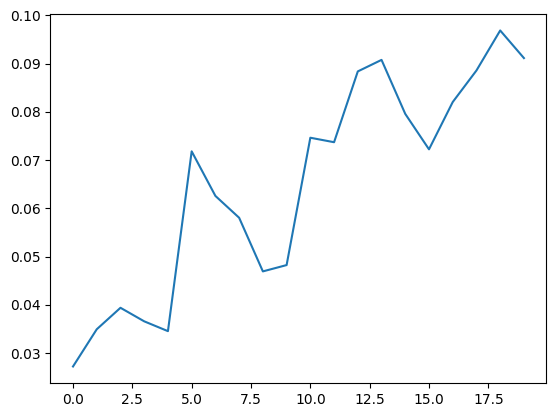

In [17]:
plt.plot(n_times,scores)

In [11]:
R_vec, score = decod_xy_word_end(X, y)


.

In [12]:
R_vec

0.16556109531306348

In [13]:
score

0.027208529598755395